In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from lapa.result import LapaResult
from met_brewer import met_brew
import matplotlib.pyplot as plt

sns.set_context('poster')

In [3]:
result = LapaResult(snakemake.input['long_read'])
samples = result.samples

In [4]:
df = result.fisher_exact_test({'undif': ['PB154', 'PB155'], 'dif': ['PB213', 'PB214']}, min_gene_count=50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14375/14375 [03:34<00:00, 67.15it/s]


In [5]:
df['-log10(p-value corrected)'] = -np.log10(df['pval_adj'])

/home/cs/anaconda3/envs/lapa/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df = df.reset_index().rename(columns={'index': 'polya_site'})
df = df.merge(pd.read_csv(snakemake.input['mapping']), on='gene_id')

In [7]:
df.loc[df['-log10(p-value corrected)'] == np.inf, '-log10(p-value corrected)'] = 300

In [8]:
df = df.loc[df.groupby('gene_id')['pval_adj'].idxmin()]

In [10]:
# colors = met_brew('Cassatt1', n=7, brew_type="continuous")

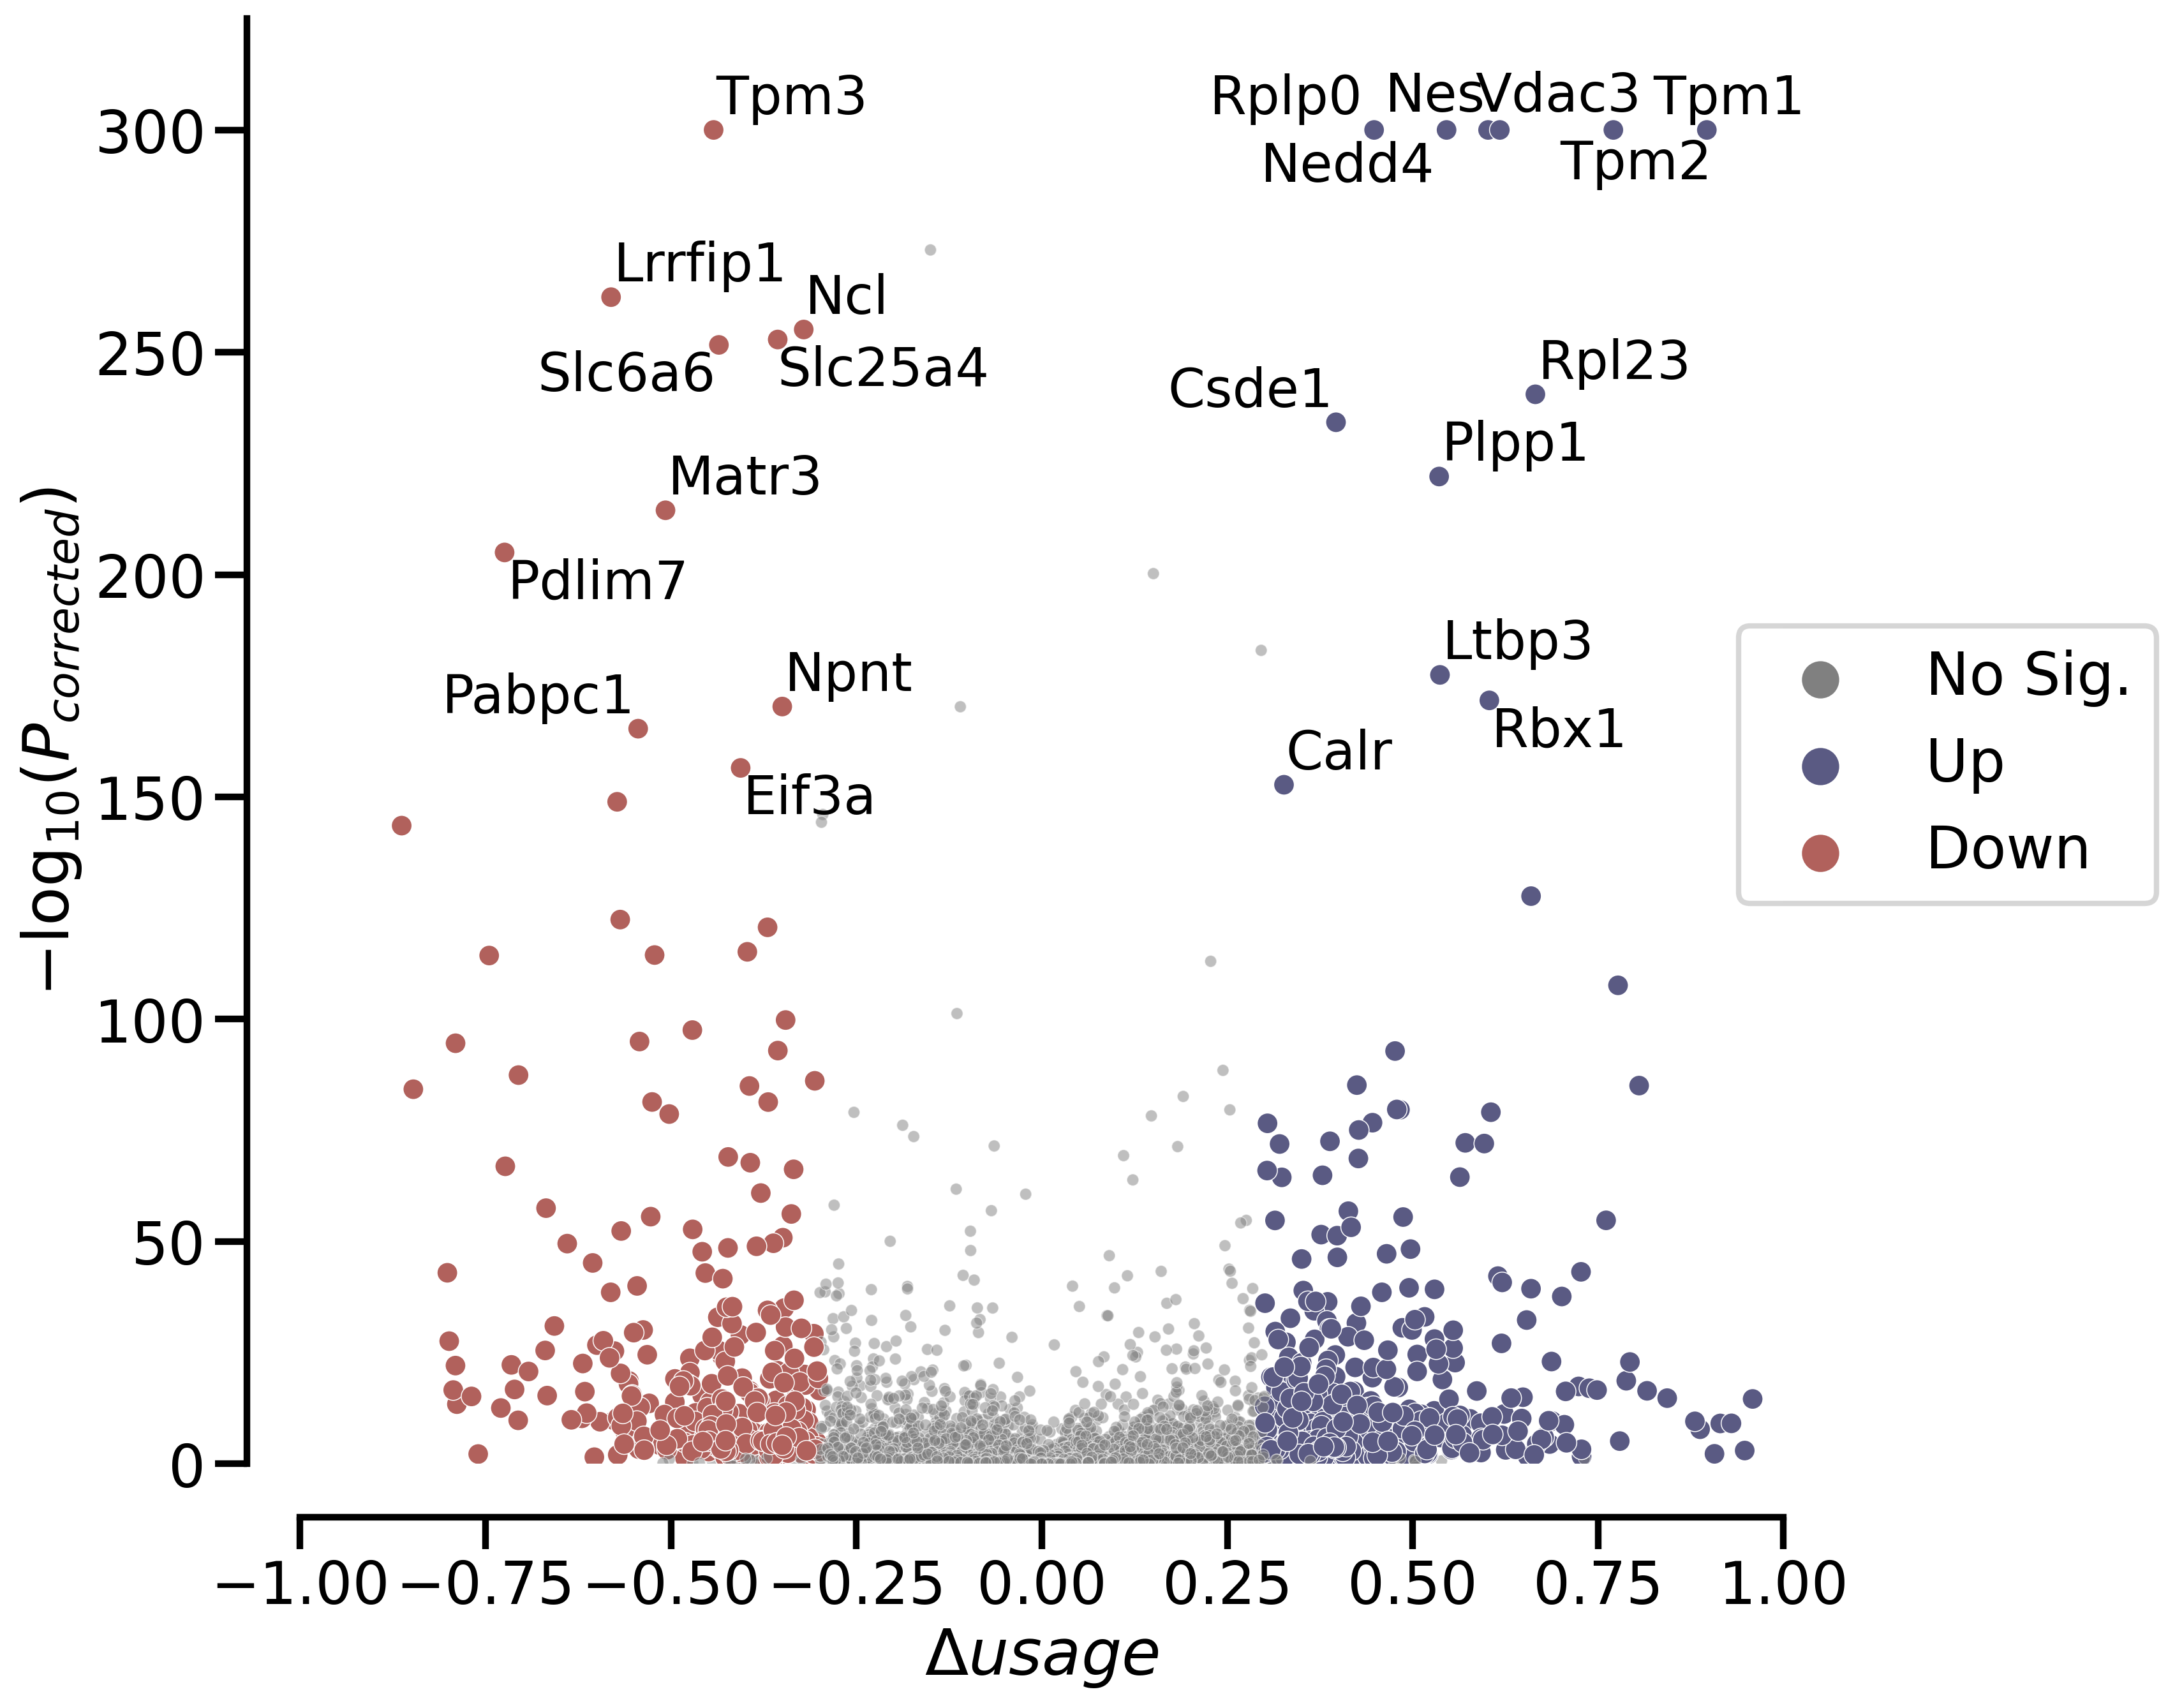

In [25]:
from adjustText import adjust_text

df['significant'] = np.where(
    (df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05),
    np.where(df['delta_usage'] > 0.3, 'Up', 'Down'),
    'No Sig.'
)

plt.figure(dpi=300, figsize=(10, 10))

sns.scatterplot(data=df, x='delta_usage', y='-log10(p-value corrected)', hue='significant',
                s = 40 * (df['significant'] != 'No Sig.') + 20, 
                palette = ['gray', '#5a5a83', '#b1615c'], 
                alpha = list(0.5 + (df['significant'] != 'No Sig.') * 0.5))

plt.legend(title=None, bbox_to_anchor=(0.95, 0.6))
plt.xlabel('$\Delta usage$')
plt.ylabel('$-\log_{10}(P_{corrected})$')

_df = df[(df['delta_usage'].abs() > 0.3) & (df['-log10(p-value corrected)'] > 150)]

text = [
    plt.text(row['delta_usage'], row['-log10(p-value corrected)'], row['gene_name'], fontsize=20)
    for _, row in _df.iterrows()
]
adjust_text(text)
sns.despine(offset=20, trim=False)

plt.xlim(-1, 1)
plt.ylim(0, 325)

plt.savefig(snakemake.output['volcona_plot'], dpi=400, bbox_inches='tight', transparent=True)

In [26]:
df = df[(df['pval_adj'] < 0.05) & (df['delta_usage'].abs() > 0.3)]

In [27]:
df.sort_values('delta_usage')

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,-log10(p-value corrected),gene_name,significant
9106,chr3:97689828:-,0.004753,9.723795e-147,-0.863134,ENSMUSG00000038170.15,2.852644e-144,143.544752,Pde4dip,Down
5909,chr19:46286510:+,0.006197,3.318272e-87,-0.847397,ENSMUSG00000025224.16,5.420474e-85,84.265963,Gbf1,Down
7318,chr2:126791568:-,0.010458,1.447815e-45,-0.801563,ENSMUSG00000027365.14,1.051128e-43,42.978344,Trpm7,Down
8957,chr3:87078600:-,0.007550,6.142227e-30,-0.799046,ENSMUSG00000041734.15,2.466327e-28,27.607949,Kirrel,Down
12699,chr8:41332340:+,0.012316,1.076650e-18,-0.793614,ENSMUSG00000031592.10,2.460548e-17,16.608968,Pcm1,Down
...,...,...,...,...,...,...,...,...,...
11868,chr7:132714201:-,inf,1.400890e-03,0.906888,ENSMUSG00000030956.15,5.438236e-03,2.264542,Fam53b,Up
2644,chr13:51701248:-,inf,6.762615e-11,0.914686,ENSMUSG00000021451.16,7.994456e-10,9.097211,Sema4d,Up
1783,chr11:96965049:+,inf,6.389192e-11,0.929762,ENSMUSG00000078700.10,7.584198e-10,9.120090,D030028A08Rik,Up
7218,chr2:119734885:+,inf,2.119639e-04,0.947637,ENSMUSG00000027304.9,9.925018e-04,3.003269,Rtf1,Up


In [28]:
usage = result.attribute('usage').loc[df['polya_site']][['PB154', 'PB155', 'PB213', 'PB214']]

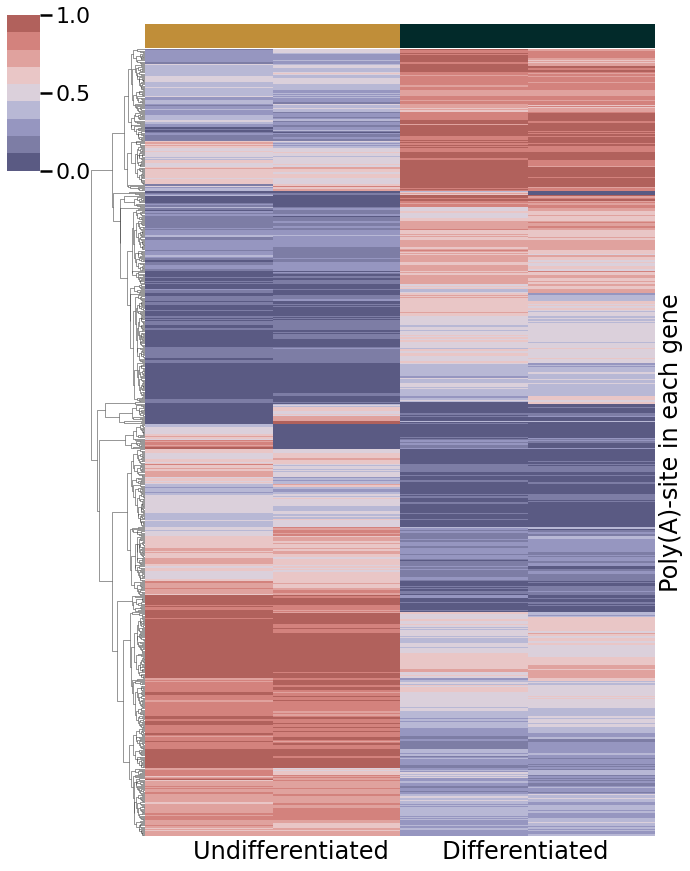

In [29]:
import seaborn as sns
import matplotlib.patches as mpatches

colors = met_brew('Cassatt1', n=9, brew_type="continuous")[::-1]

col_colors = met_brew('Nattier')
col_colors = [col_colors[2], col_colors[4]]

fig = sns.clustermap(usage.fillna(0), figsize=(9, 12),
                     col_colors=[col_colors[0], col_colors[0], col_colors[1], col_colors[1]],
                     xticklabels=False, yticklabels=False, col_cluster=False,
                     cmap=sns.color_palette(colors, as_cmap=True), 
                     cbar_pos=(-0.085, 0.8, 0.05, 0.18), dendrogram_ratio=(0.1, 0))

fig.ax_heatmap.set_xlabel('Undifferentiated' + ' ' * 7 +'Differentiated')
fig.ax_heatmap.set_ylabel('Poly(A)-site in each gene')

plt.savefig(snakemake.output['heatmap_plot'], dpi=400, bbox_inches='tight', transparent=True)